# Homework 8: Clustering

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Mall Customers Dataset

In this assignment, you will work on customer segmentation using clustering techniques.

The dataset for this assignment is the **Mall Customers Dataset**, which contains customer data collected from a shopping mall. It includes:

- **CustomerID**: Unique identifier for each customer (not useful for clustering).
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Annual Income (k)**: Annual income in thousands of dollars.
- **Spending Score (1-100)**: A metric indicating customer spending habits.

The goal is to segment customers based on their characteristics using different clustering methods.


In [1]:
import numpy as np
import polars as pl
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Plotting
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

1. Load the CSV file. Display the summary statistics for the dataset and check if there are any null values in the dataset. Use polars unless your operators do not allow it (transforming them to pandas or numpy at that stage).

In [2]:
# YOUR CODE HERE
mall = pl.read_csv("Mall_Customers.csv")
mall.describe()

statistic,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
str,f64,str,f64,f64,f64
"""count""",200.0,"""200""",200.0,200.0,200.0
"""null_count""",0.0,"""0""",0.0,0.0,0.0
"""mean""",100.5,null,38.85,60.56,50.2
"""std""",57.879185,null,13.969007,26.264721,25.823522
"""min""",1.0,"""Female""",18.0,15.0,1.0
"""25%""",51.0,null,29.0,42.0,35.0
"""50%""",101.0,null,36.0,62.0,50.0
"""75%""",150.0,null,49.0,78.0,73.0
"""max""",200.0,"""Male""",70.0,137.0,99.0


In [3]:
# YOUR CODE HERE
print(mall.head())
print(mall.unique(subset=["Genre"]))


shape: (5, 5)
┌────────────┬────────┬─────┬────────────────────┬────────────────────────┐
│ CustomerID ┆ Genre  ┆ Age ┆ Annual Income (k$) ┆ Spending Score (1-100) │
│ ---        ┆ ---    ┆ --- ┆ ---                ┆ ---                    │
│ i64        ┆ str    ┆ i64 ┆ i64                ┆ i64                    │
╞════════════╪════════╪═════╪════════════════════╪════════════════════════╡
│ 1          ┆ Male   ┆ 19  ┆ 15                 ┆ 39                     │
│ 2          ┆ Male   ┆ 21  ┆ 15                 ┆ 81                     │
│ 3          ┆ Female ┆ 20  ┆ 16                 ┆ 6                      │
│ 4          ┆ Female ┆ 23  ┆ 16                 ┆ 77                     │
│ 5          ┆ Female ┆ 31  ┆ 17                 ┆ 40                     │
└────────────┴────────┴─────┴────────────────────┴────────────────────────┘
shape: (2, 5)
┌────────────┬────────┬─────┬────────────────────┬────────────────────────┐
│ CustomerID ┆ Genre  ┆ Age ┆ Annual Income (k$) ┆ Spending 

2. For the clustering analyses, consider only the numerical variables. Therefore you should drop 'Genre' from the dataset. Standardize the remaining variables, excluding the ID, ensuring they have mean of zero and standard deviation of one.

In the following lines you should:

- Update the dataset to include only numerical features and display the first 10 rows of the updated dataset.

- Standardize the features.

In [4]:
# YOUR CODE HERE
mall = mall.drop("CustomerID")
mall = mall.drop("Genre")
mall.head(10)

Age,Annual Income (k$),Spending Score (1-100)
i64,i64,i64
19,15,39
21,15,81
20,16,6
23,16,77
31,17,40
22,17,76
35,18,6
23,18,94
64,19,3


In [5]:
# YOUR CODE HERE
scaler = StandardScaler()
mall_scaled = pd.DataFrame(scaler.fit_transform(mall.to_pandas()), columns=mall.columns)

## K-means

3. Use the K-means method to perform clustering on the scaled data from Q2, setting `random_state = 2025`. Determine the optimal number of clusters using the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)  function with `k=(2,12)`.



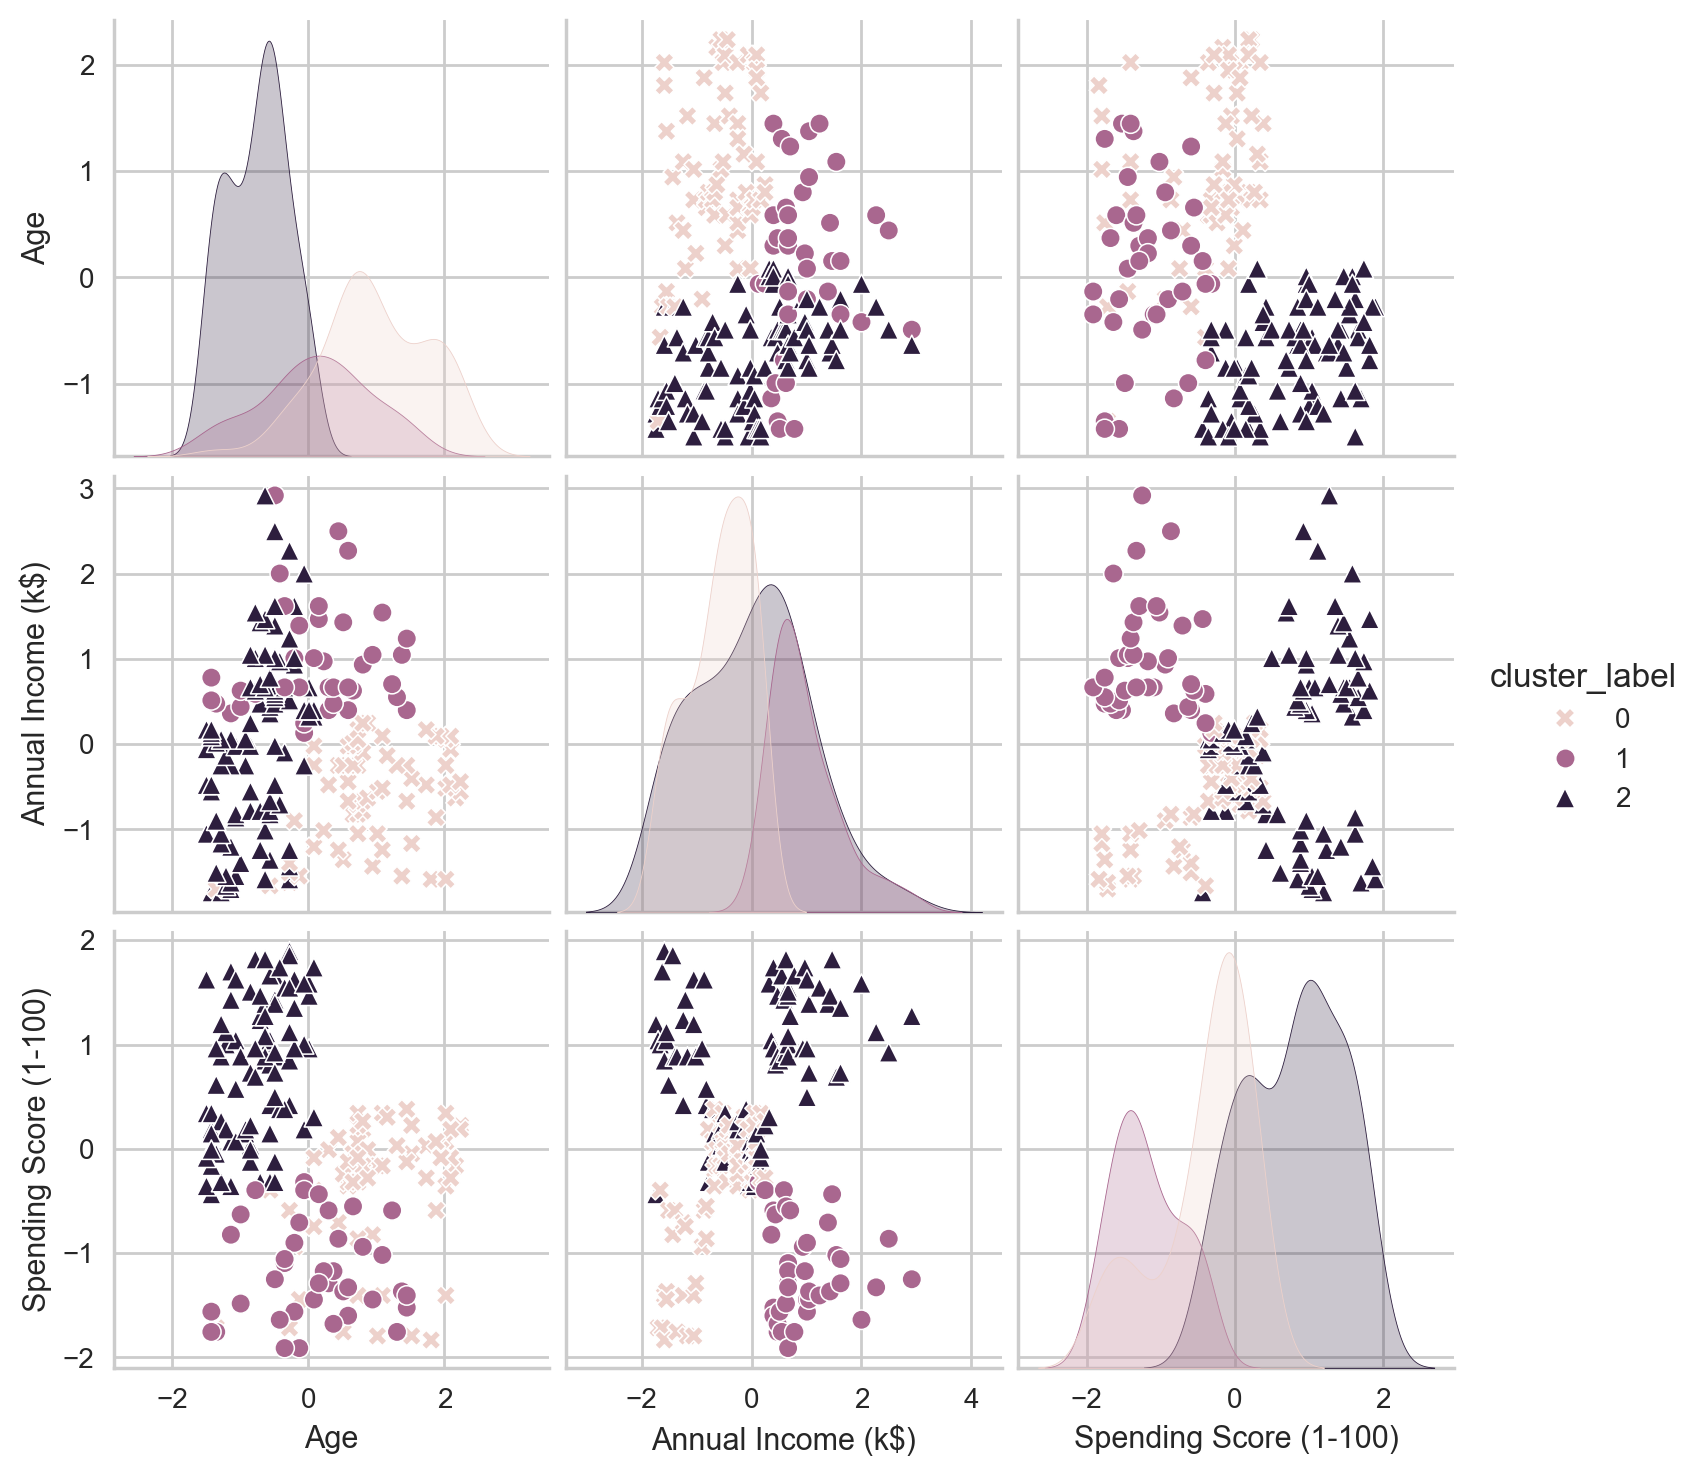

In [6]:
# YOUR CODE HERE
KClusterer = KMeans(n_clusters=3,
                   verbose=0,
                   random_state=2025) # Name of operator and cluster number

mall2 = mall_scaled.copy()
mall2['cluster_label'] = KClusterer.fit_predict(mall_scaled)


sns.pairplot(vars=mall_scaled.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^'],      # Differentiate markers
             data=mall2,                     # What data to use
            )

plt.show()



<bound method Visualizer.show of KElbowVisualizer(ax=<Axes: >,
                 estimator=KMeans(n_clusters=11, random_state=2025), k=(2, 12),
                 timings=False)>

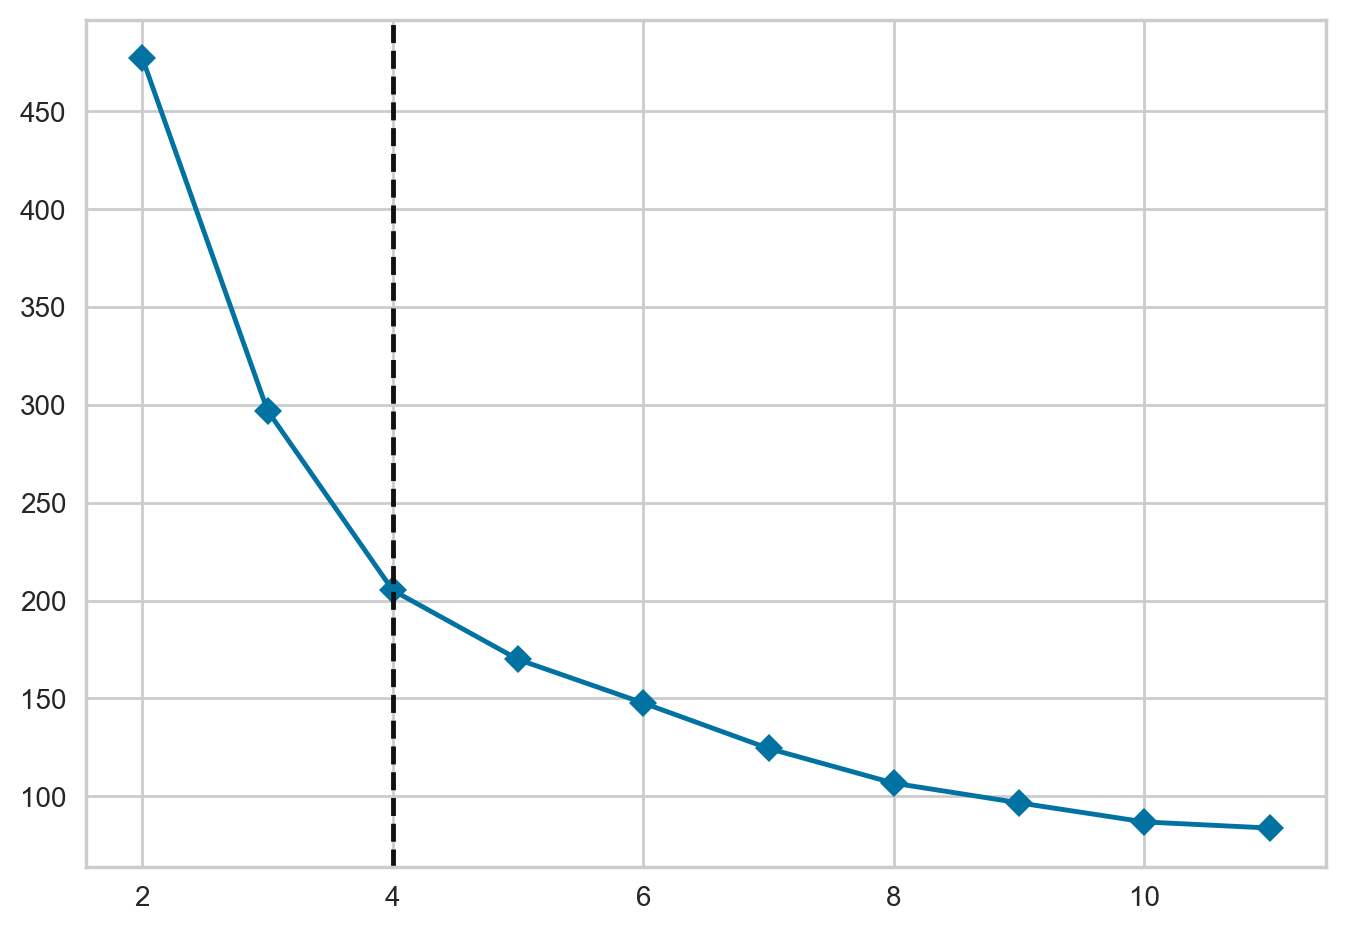

In [7]:
visualizer = KElbowVisualizer(KClusterer,
                              k=(2,12),
                              locate_elbow=True,
                              timings=False)

visualizer.fit(mall_scaled)
visualizer.show


**Written answer: What is the optimal number of clusters using the elbow method?** 

**ANSWER HERE:** The optimal number of clusters using the elbow method is 4 clusters

4. Fit a K-means model on the scaled data using the optimal number of clusters identified in Q3. Then, visualize the resulting clusters using a scatterplot matrix (`sns.pairplot`).

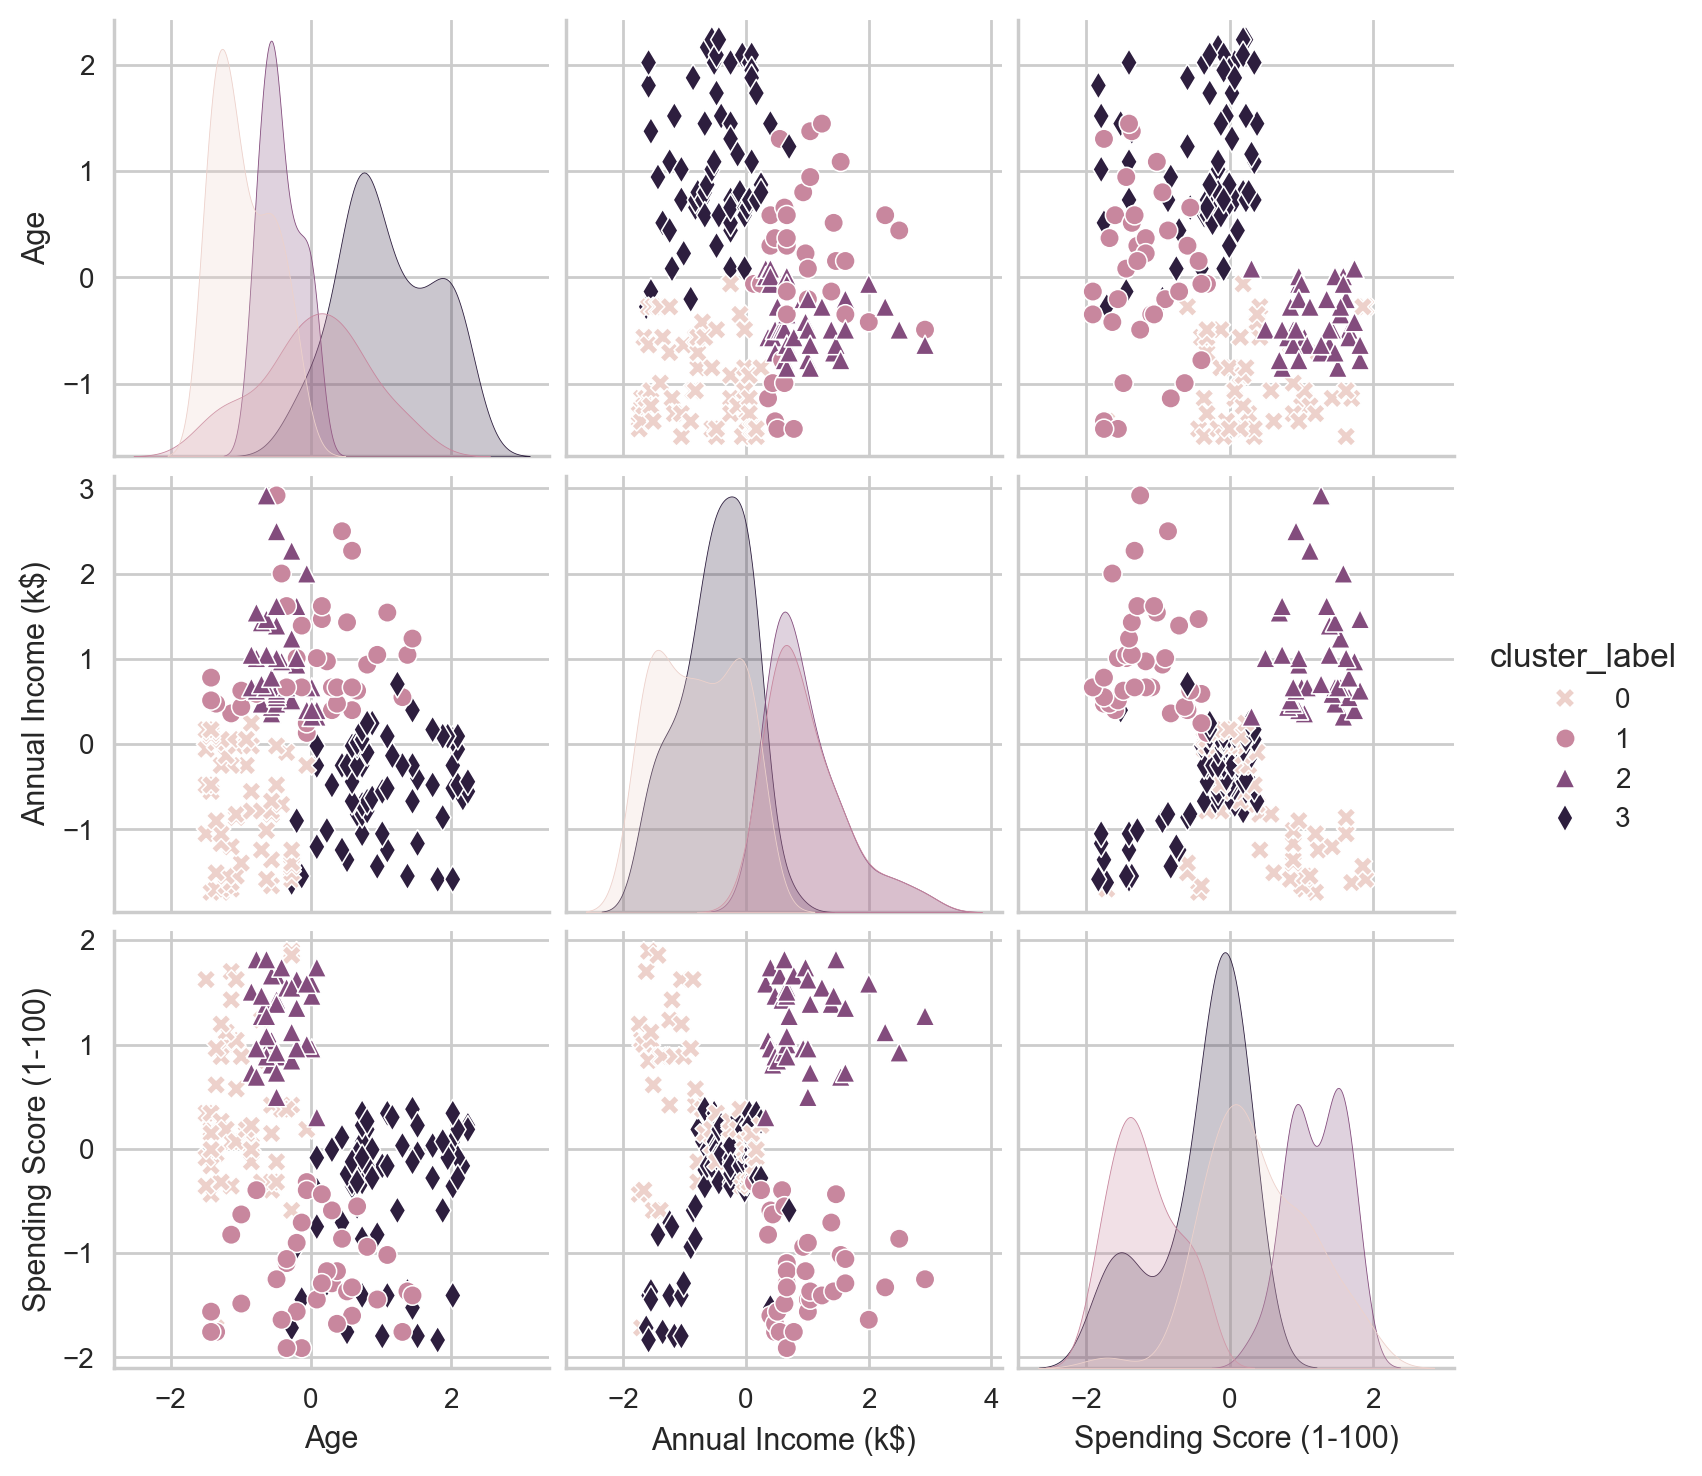

In [8]:
# YOUR CODE HERE
KClusterer = KMeans(n_clusters=4,
                    verbose=0,
                    random_state=2025)

mall2 = mall_scaled.copy()
mall2['cluster_label'] = KClusterer.fit_predict(mall_scaled)

sns.pairplot(vars=mall_scaled.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^', 'd'],      # Differentiate markers
             data=mall2,                     # What data to use
            )

plt.show()

5. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the clusters from Q4, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster by analyzing their defining features, such as whether they represent high-income spenders, budget-conscious customers, or younger versus older groups.

In [9]:
# YOUR CODE HERE
mall_np = mall.to_numpy()
cluster_labels = KClusterer.fit_predict(mall_np)
mall3 = mall.with_columns(pl.Series("cluster_label", cluster_labels))

cluster_avg = mall3.group_by("cluster_label").agg([
    pl.col(column).mean().alias(f"{column}_mean") for column in mall3.columns if column != "cluster_label"
])
print(cluster_avg.sort('cluster_label'))

shape: (4, 4)
┌───────────────┬───────────┬─────────────────────────┬─────────────────────────────┐
│ cluster_label ┆ Age_mean  ┆ Annual Income (k$)_mean ┆ Spending Score (1-100)_mean │
│ ---           ┆ ---       ┆ ---                     ┆ ---                         │
│ i32           ┆ f64       ┆ f64                     ┆ f64                         │
╞═══════════════╪═══════════╪═════════════════════════╪═════════════════════════════╡
│ 0             ┆ 24.479167 ┆ 39.895833               ┆ 64.416667                   │
│ 1             ┆ 32.692308 ┆ 86.538462               ┆ 82.128205                   │
│ 2             ┆ 40.394737 ┆ 87.0                    ┆ 18.631579                   │
│ 3             ┆ 50.466667 ┆ 46.88                   ┆ 40.493333                   │
└───────────────┴───────────┴─────────────────────────┴─────────────────────────────┘


**Written answer:** Clusters 0-3 capture increasingly older ages, with the youngest being cluster 0 at an average age of 24.47, while the oldest cluster 3 is a mean age of 50.46 years old. Surprisingly, the oldest age group, cluster 3, has the least income. Otherwise, income does increase as people get older. This may be due to retirement. Finally, there is no good trend to spending scores. In early life, spending increases, but finds a sharp decline in the age group with a mean of 40.39 (cluster 2). Then, spending scores increase to the next cluster. 


## Agglomerative clustering

6. Use Agglomerative Clustering with `linkage='average'` to determine the best number of clusters (between 3 and 7) using silhouette analysis.

For each number of clusters:

- Compute and print the average silhouette score.
- Generate and display a silhouette plot.

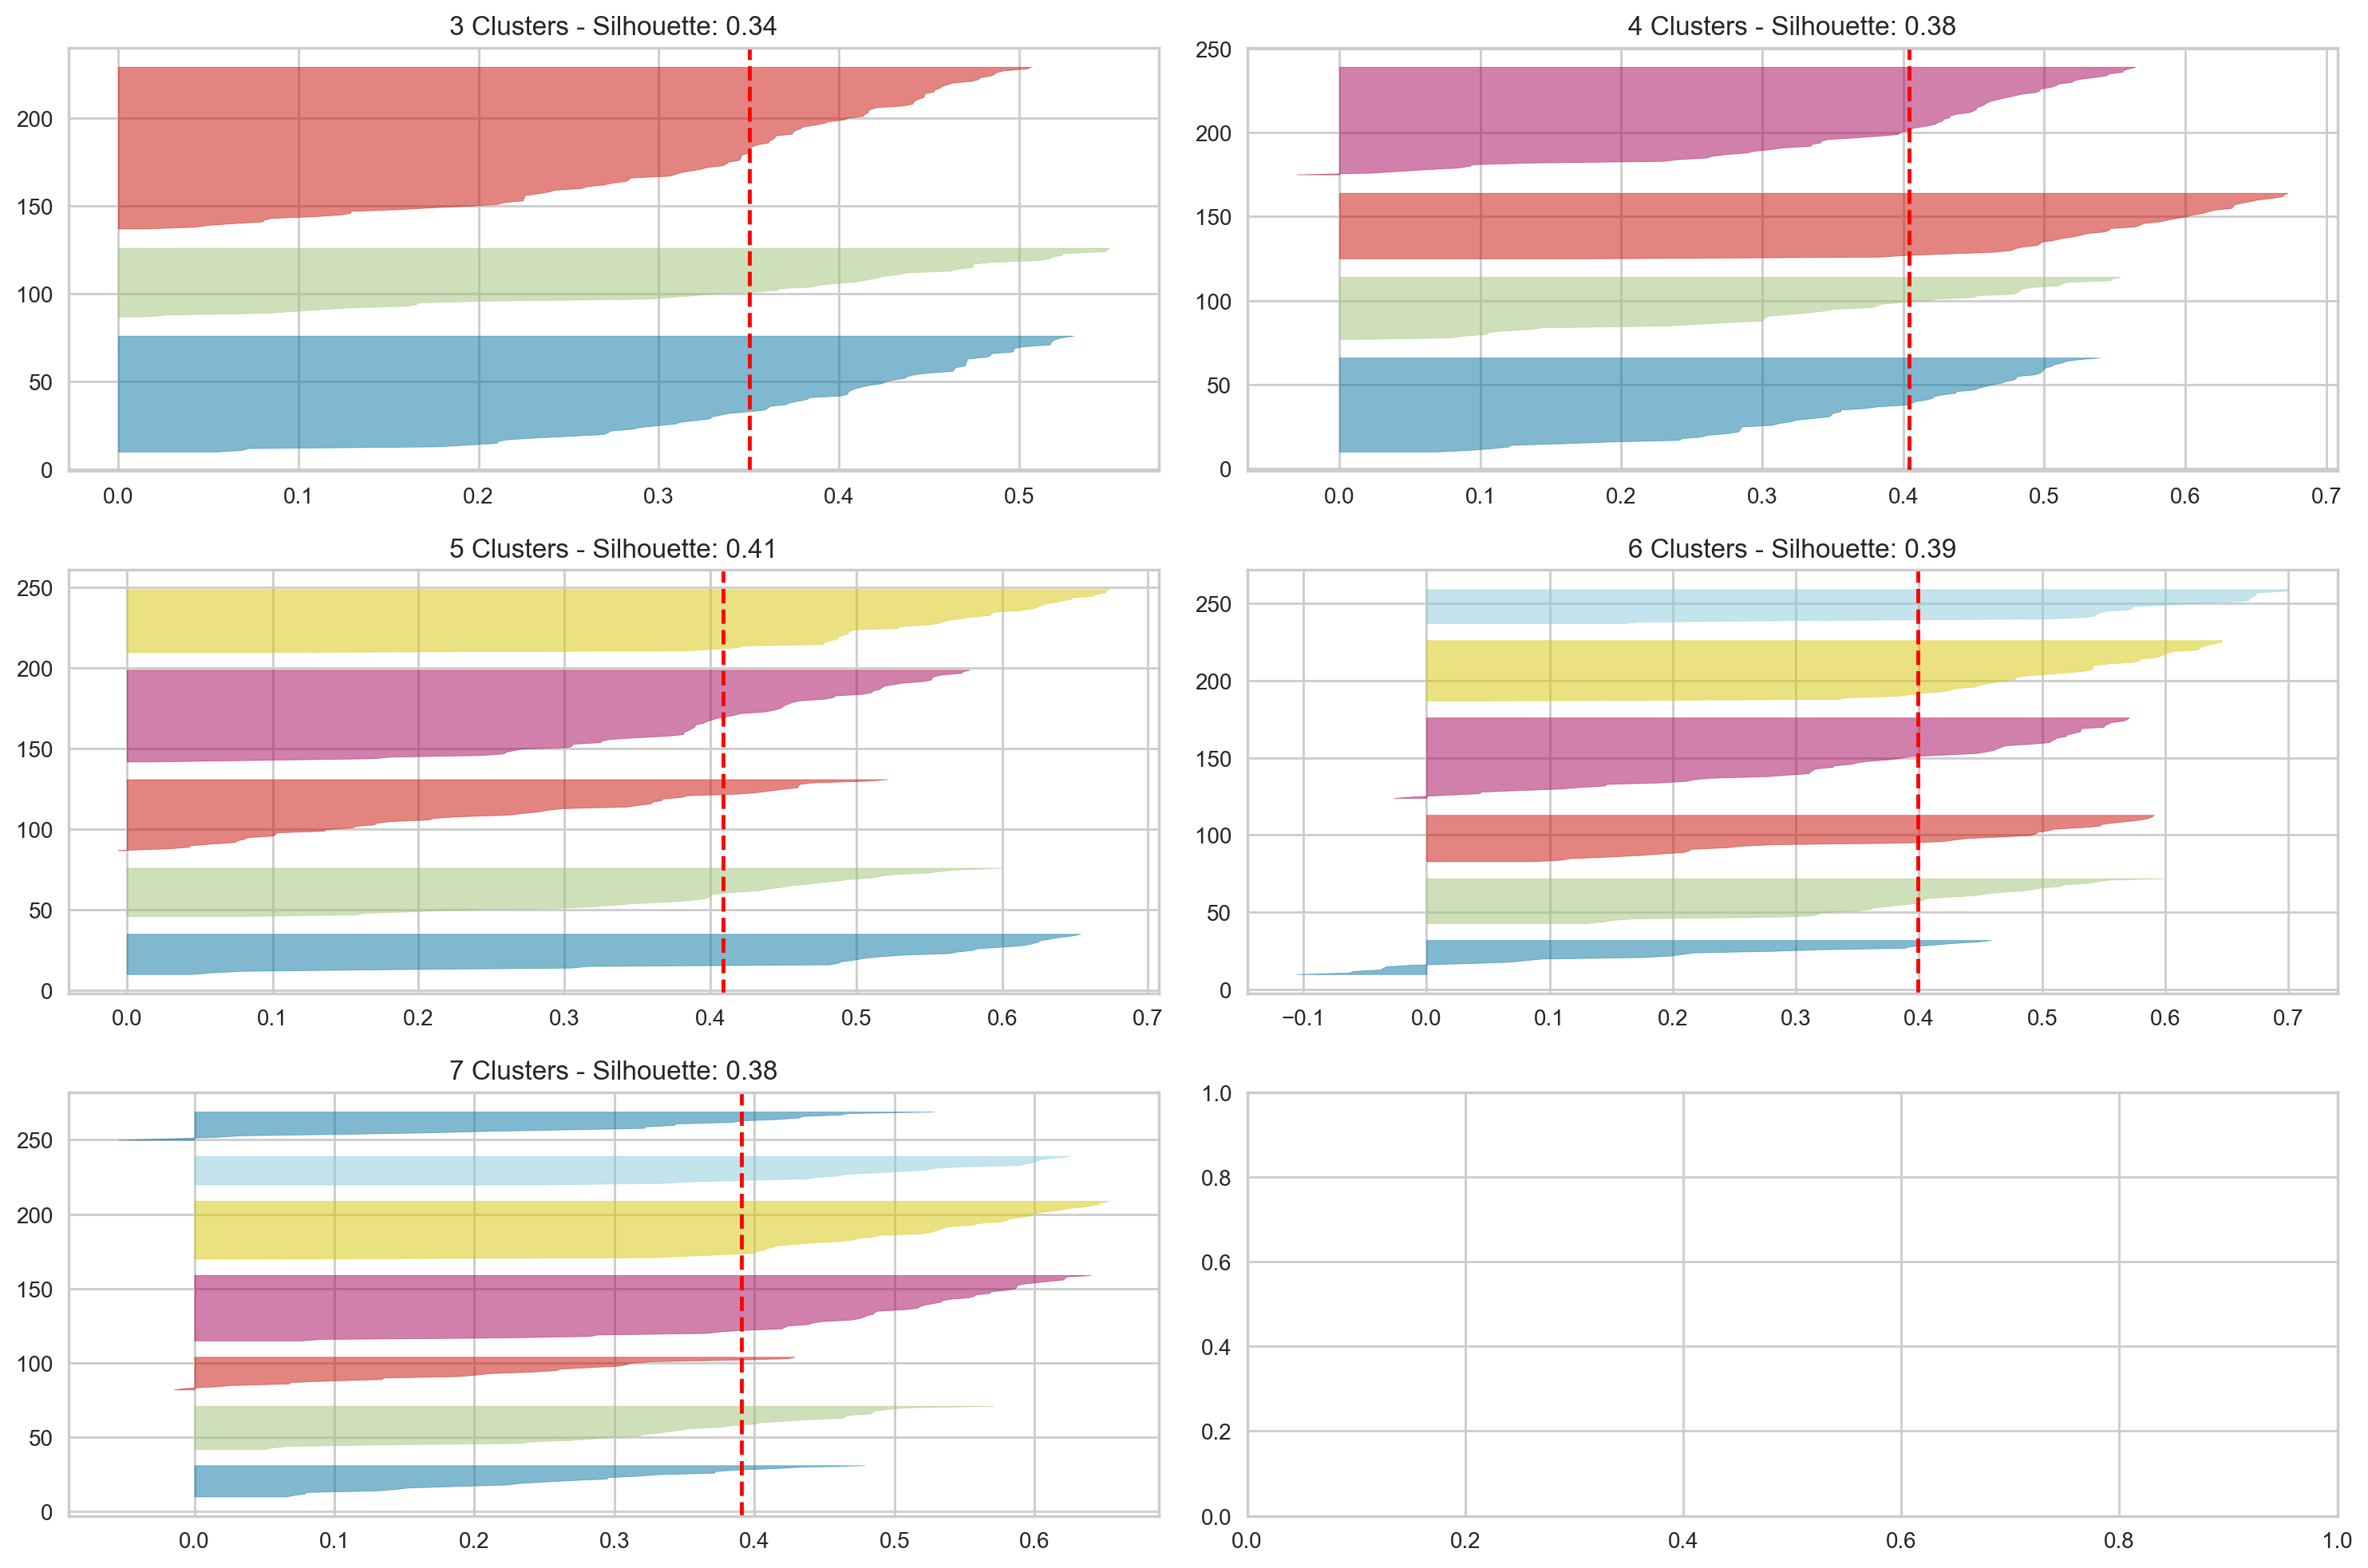

Silhouette Scores: [np.float64(0.33996187294272745), np.float64(0.3839056982213577), np.float64(0.40956924875250705), np.float64(0.38957308601543233), np.float64(0.38004372171306033)]


In [10]:
# YOUR CODE HERE

fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.flatten()
sil_scores = []

for i in range(3,8):
    Agglomerativemall = AgglomerativeClustering(n_clusters=i,         # Number of clusters
                                            metric="euclidean",    # Distance metric
                                            linkage="average"      # Type of linkage.
                                            )
    cluster_labels = Agglomerativemall.fit_predict(mall_scaled)
    sil_avg = silhouette_score(mall_scaled, cluster_labels)
    sil_scores.append(sil_avg)
    
    kmeans = KMeans(n_clusters=i, random_state = 2025)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[i-3])
    visualizer.fit(mall_scaled)  # Fit only the scaled data, not cluster labels
    axes[i-3].set_title(f"{i} Clusters - Silhouette: {sil_avg:.2f}")
    
plt.tight_layout()
plt.show()
print("Silhouette Scores:", sil_scores)
    


**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**ANSWER HERE:** The 5 cluster silhouette analysis yielded the best silhouette score and appears to have similar widths across all the clusters. Furthermore, there are no negative values which would indicate poor clustering.

7. Fit the Agglomerative clustering on the scaled data using the optimal number of clusters identified in Q6. Then, visualize the resulting clusters using scatterplots.

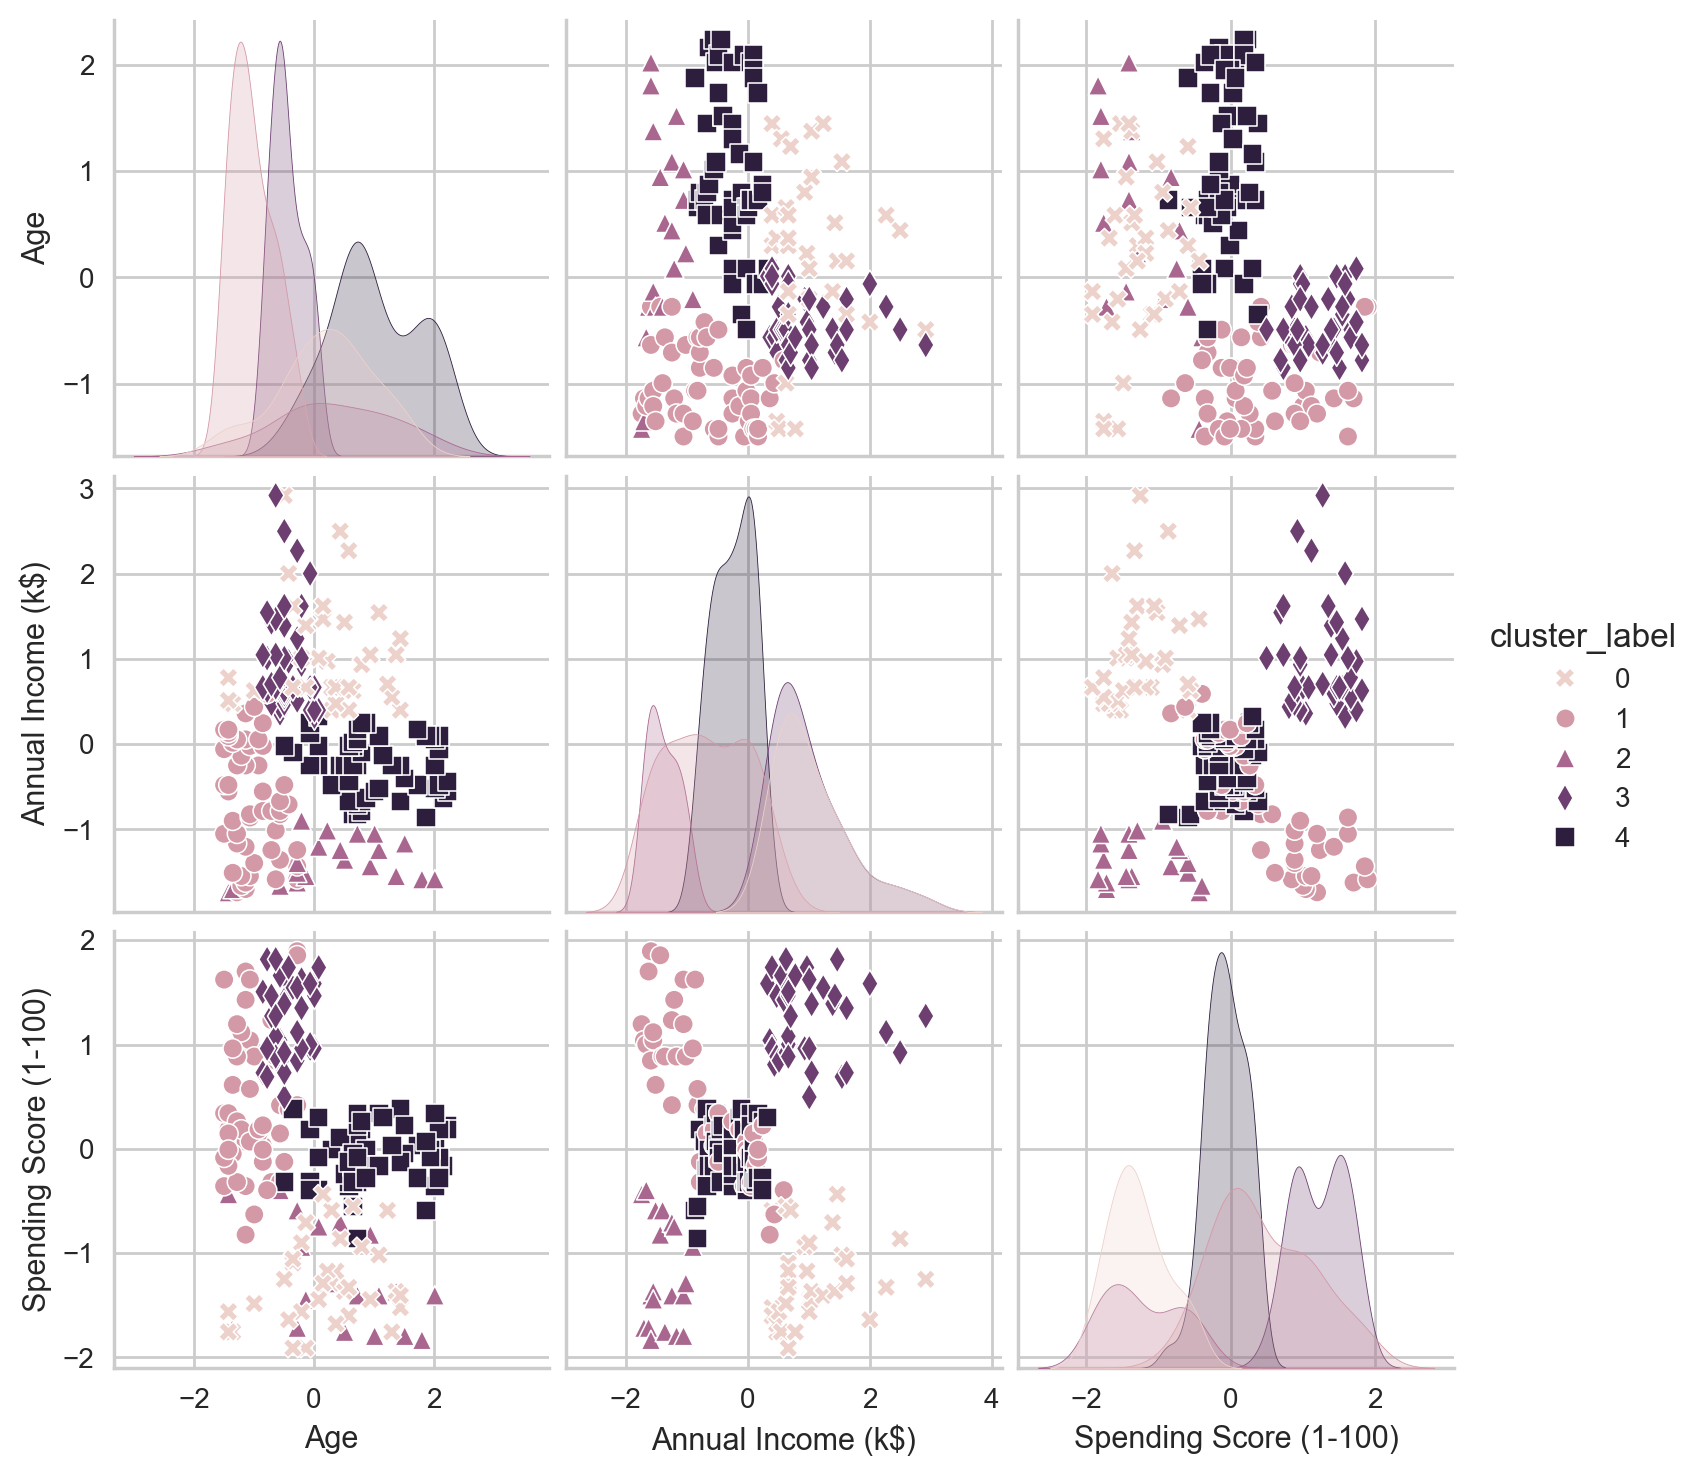

In [11]:
# YOUR CODE HERE
Agglomerativemall = AgglomerativeClustering(n_clusters=5,         # Number of clusters
                                            metric="euclidean",    # Distance metric
                                            linkage="average"      # Type of linkage.
                                            )
mall2 = mall_scaled.copy()
mall2['cluster_label'] = Agglomerativemall.fit_predict(mall_scaled)

sns.pairplot(vars=mall_scaled.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^', 'd', 's'],      # Differentiate markers
             data=mall2,                     # What data to use
            )

plt.show()

8. Using the clusters from Q7, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [12]:
# YOUR CODE HERE
mall_np = mall.to_numpy()
cluster_labels = Agglomerativemall.fit_predict(mall_np)
mall3 = mall.with_columns(pl.Series("cluster_label", cluster_labels))

cluster_avg = mall3.group_by("cluster_label").agg([
    pl.col(column).mean().alias(f"{column}_mean") for column in mall3.columns if column != "cluster_label"
])
print(cluster_avg.sort('cluster_label'))

shape: (5, 4)
┌───────────────┬───────────┬─────────────────────────┬─────────────────────────────┐
│ cluster_label ┆ Age_mean  ┆ Annual Income (k$)_mean ┆ Spending Score (1-100)_mean │
│ ---           ┆ ---       ┆ ---                     ┆ ---                         │
│ i64           ┆ f64       ┆ f64                     ┆ f64                         │
╞═══════════════╪═══════════╪═════════════════════════╪═════════════════════════════╡
│ 0             ┆ 41.685714 ┆ 88.228571               ┆ 17.285714                   │
│ 1             ┆ 42.097561 ┆ 54.902439               ┆ 49.878049                   │
│ 2             ┆ 32.692308 ┆ 86.538462               ┆ 82.128205                   │
│ 3             ┆ 24.85     ┆ 24.95                   ┆ 81.0                        │
│ 4             ┆ 45.291667 ┆ 27.0                    ┆ 21.75                       │
└───────────────┴───────────┴─────────────────────────┴─────────────────────────────┘


**Written answer:**
Now, we see less of a trend across ages. 3 of the clusters have similar age means while 2 of them are younger. For the younger clusters, the older group at 32.69 years old has a far greater income and has a higher spending score than all the other clusters. The younger group at 24.85 years old has less income, but spends on the same level as the 32 year old group. Among the older clusters, they are separated by their annual income rather than by age as they are all within 4 years of each other. Since some of the older groups earn more than their counterparts, they naturally also spend differently. 

There is potential that the lowest earnings older cluster is a retired group, while the two with greater incomes are working. 

## Spectral Clustering

9. Use Spectral Clustering to determine the best number of clusters (between 3 and 8) using silhouette analysis.

Set the parameters:
- `affinity = 'nearest_neighbors'`
- `n_jobs = -1`
- `n_neighbors = 10`
- `random_state = 2025`


For each number of clusters:

- Compute and display the average silhouette score
- Generate the silhouette plot.



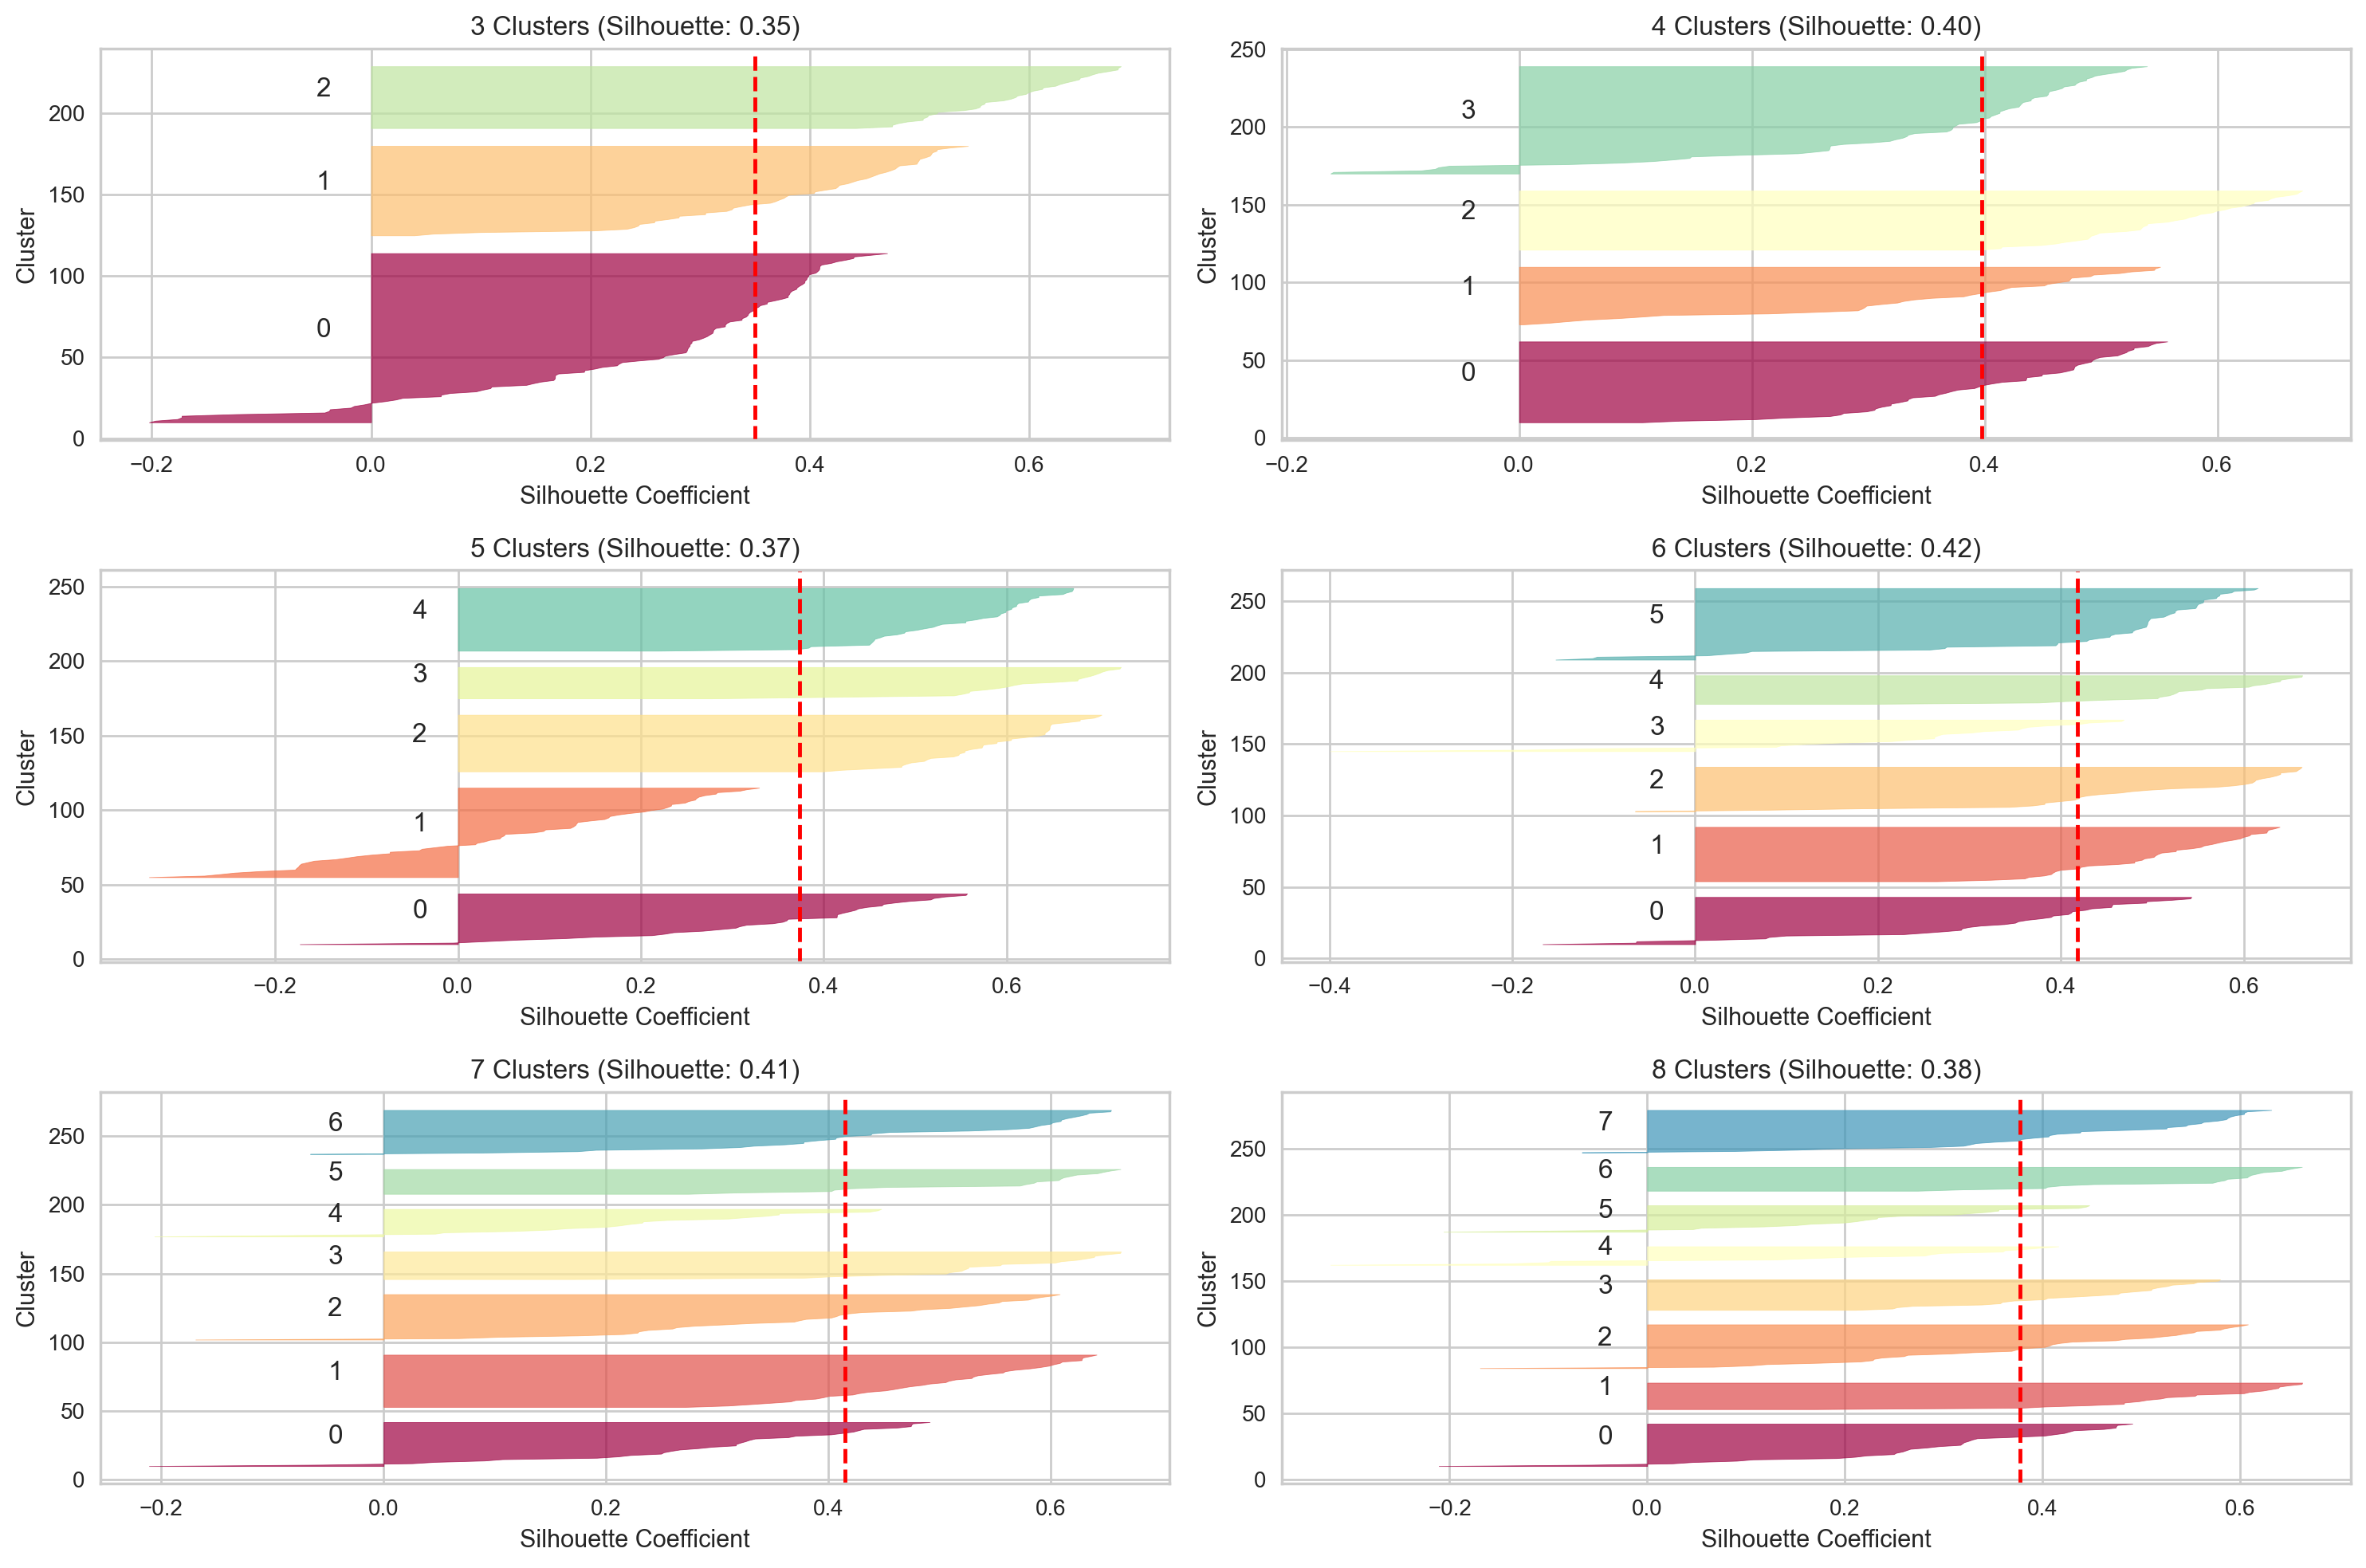

Silhouette Scores: [np.float64(0.34962290650195027), np.float64(0.3978090170232268), np.float64(0.3734062594415012), np.float64(0.41814947016089815), np.float64(0.41481782138552725), np.float64(0.3776541639639813)]


In [13]:
# YOUR CODE HERE
fig, axes = plt.subplots(3, 2, figsize=(15,10))
axes = axes.flatten()
sil_scores = []

for i in range(3,9):
    spectral_model = SpectralClustering(n_clusters=i,  # Number of clusters to train.
                                    affinity='nearest_neighbors',
                                    n_jobs=-1,
                                    n_neighbors=10,
                                    random_state=2025)
    cluster_labels = spectral_model.fit_predict(mall_scaled)
    sil_avg = silhouette_score(mall_scaled, cluster_labels)
    sil_scores.append(sil_avg)
    
    # Manual Silhouette Plot
    ax = axes[i-3]
    sil_samples = silhouette_samples(mall_scaled, cluster_labels)
    y_lower = 10  # Space between clusters
    
    for j in range(i):
        jth_cluster_sil = sil_samples[cluster_labels == j]
        jth_cluster_sil.sort()
        
        y_upper = y_lower + len(jth_cluster_sil)
        color = plt.colormaps["Spectral"](j / i)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, jth_cluster_sil,
            facecolor=color, edgecolor=color, alpha=0.7
        )
        ax.text(-0.05, y_lower + 0.5 * len(jth_cluster_sil), str(j))
        y_lower = y_upper + 10  # Add space for next cluster
    
    ax.set_title(f"{i} Clusters (Silhouette: {sil_avg:.2f})")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.axvline(x=sil_avg, color="red", linestyle="--")  # Avg line
    
plt.tight_layout()
plt.show()
print("Silhouette Scores:", sil_scores)

**Written Answer:** How many clusters were select based on the Silhouette analysis? Explain your answer.

**Written answer:** 6 clusters were selected. This is from looking at the highest silhouette score, and noticing that 6 clusters has minimal negative values. There can be a case made for 7 clusters too since the width of the clusters appears to be more uniform with less negative values, but the highest silhouette score is given to 6 clusters.

10. Fit a Spectral Clustering on the scaled data using the optimal number of clusters identified in Q9. Then, visualize the resulting clusters using scatterplots.

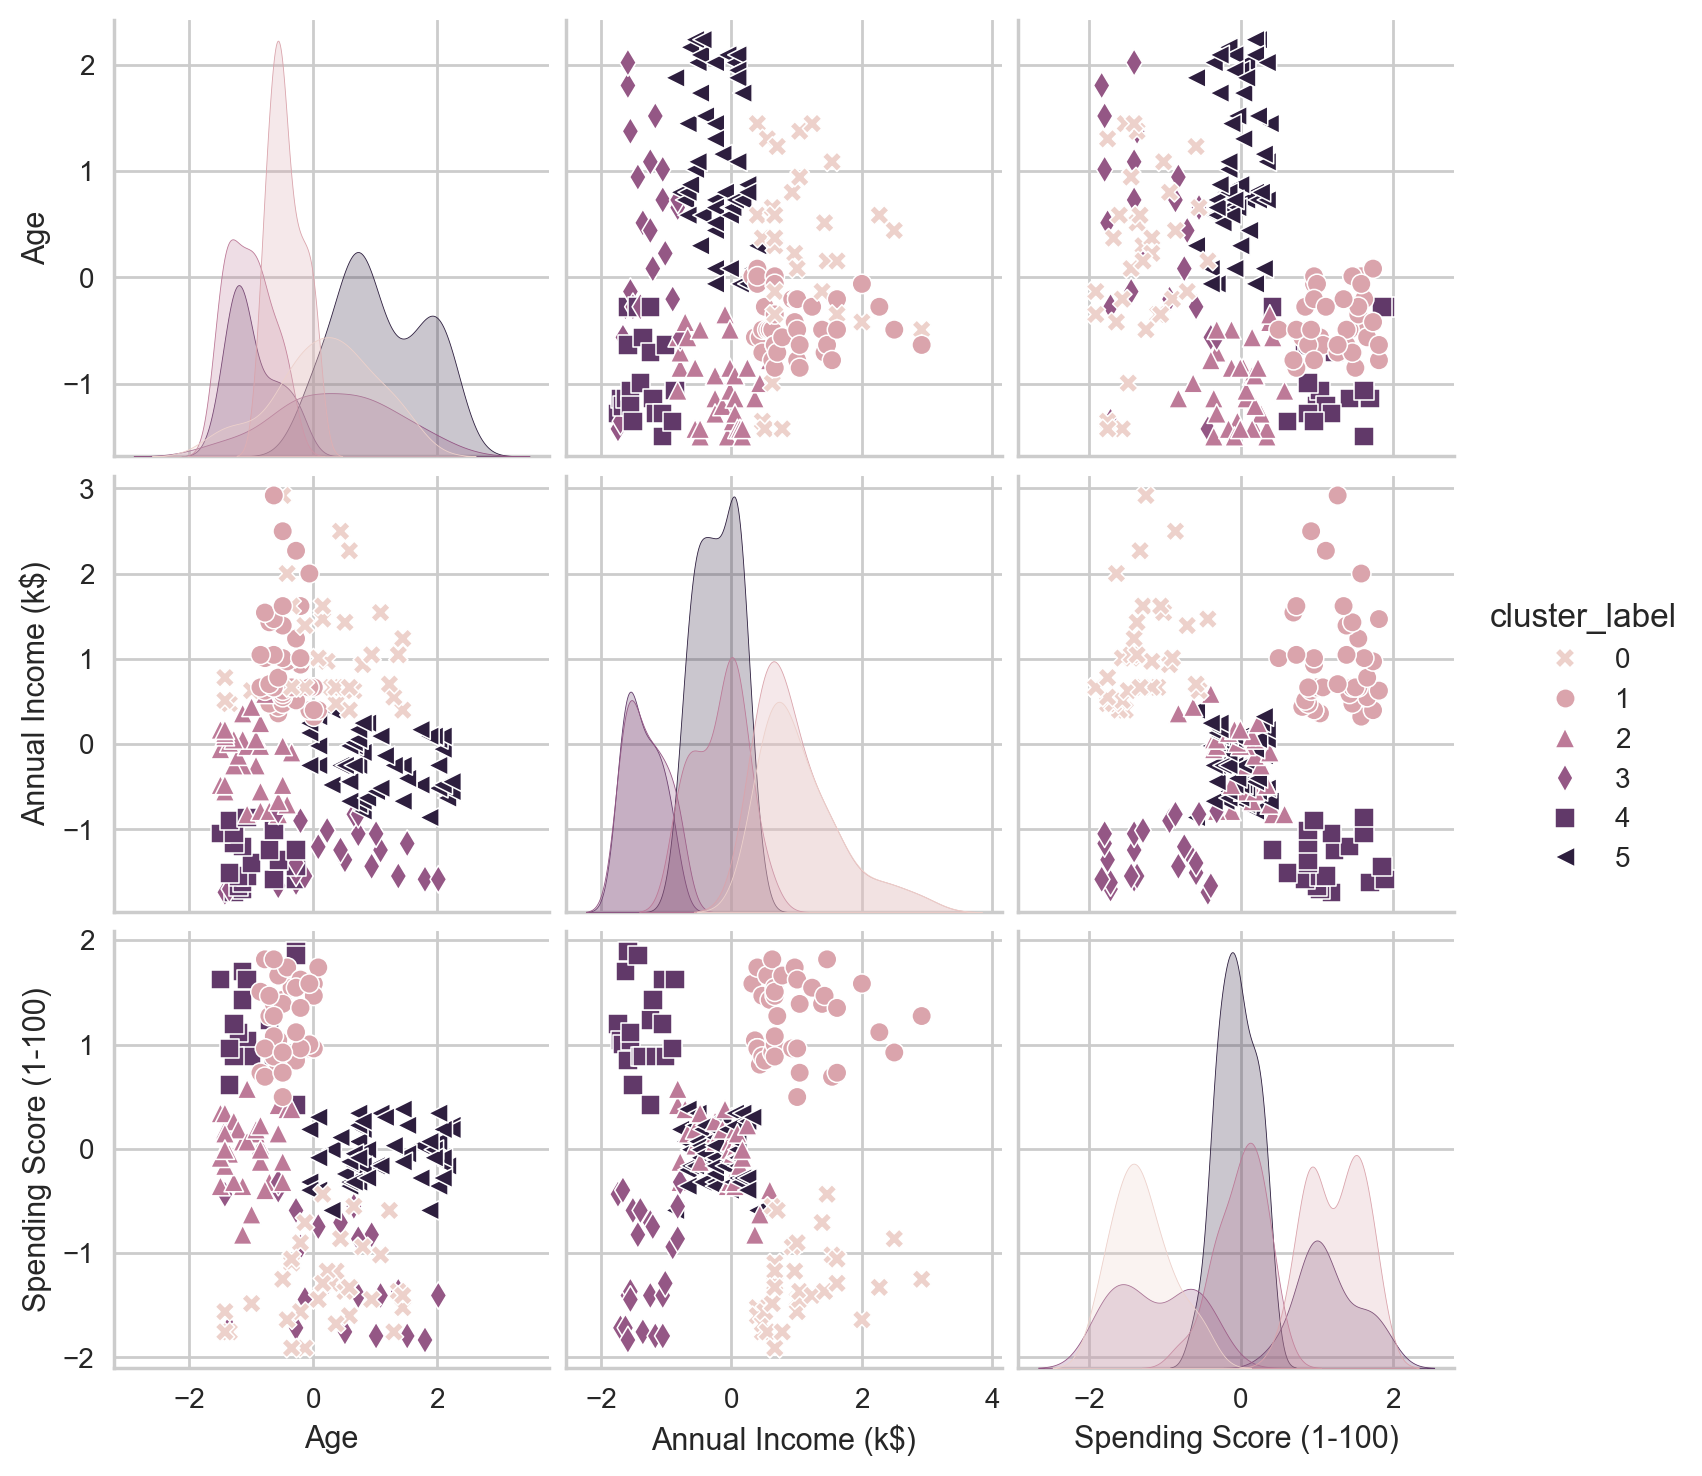

In [14]:
# YOUR CODE HERE
spectral_model = SpectralClustering(n_clusters=6,  # Number of clusters to train.
                                    affinity='nearest_neighbors',
                                    n_jobs=-1,
                                    n_neighbors=10,
                                    random_state=2025)
mall2 = mall_scaled.copy()
mall2['cluster_label'] = spectral_model.fit_predict(mall_scaled)

sns.pairplot(vars=mall_scaled.columns, # Variable names
             hue='cluster_label',        # How to colour the points. Use cluster labels
             markers=['X','o','^', 'd', 's', '<'],      # Differentiate markers
             data=mall2,                     # What data to use
            )

plt.show()

11. Using the clusters from Q10, create a table showing the average values per variable (Age, Annual income, and Spending scores) for each cluster. Use the original, non-scaled variables. Interpret the characteristics of each cluster.

In [15]:
# YOUR CODE HERE
mall_np = mall.to_numpy()
cluster_labels = spectral_model.fit_predict(mall_np)
mall3 = mall.with_columns(pl.Series("cluster_label", cluster_labels))

cluster_avg = mall3.group_by("cluster_label").agg([
    pl.col(column).mean().alias(f"{column}_mean") for column in mall3.columns if column != "cluster_label"
])
print(cluster_avg.sort('cluster_label'))

shape: (6, 4)
┌───────────────┬───────────┬─────────────────────────┬─────────────────────────────┐
│ cluster_label ┆ Age_mean  ┆ Annual Income (k$)_mean ┆ Spending Score (1-100)_mean │
│ ---           ┆ ---       ┆ ---                     ┆ ---                         │
│ i32           ┆ f64       ┆ f64                     ┆ f64                         │
╞═══════════════╪═══════════╪═════════════════════════╪═════════════════════════════╡
│ 0             ┆ 41.212121 ┆ 89.030303               ┆ 16.212121                   │
│ 1             ┆ 32.692308 ┆ 86.538462               ┆ 82.128205                   │
│ 2             ┆ 54.392157 ┆ 55.431373               ┆ 48.45098                    │
│ 3             ┆ 25.117647 ┆ 55.235294               ┆ 50.117647                   │
│ 4             ┆ 25.333333 ┆ 25.095238               ┆ 80.047619                   │
│ 5             ┆ 44.318182 ┆ 25.772727               ┆ 20.272727                   │
└───────────────┴───────────┴───────────

**Written answer:** With 6 clusters, we see a split in the youngest cluster, separating them by annual income. One group (cluster 3) has a higher income than the other (cluster 4) while also having a lower spending score, which can imply better financial wellness. 

In cluster 0, this is the middle age group that is similar in age to cluster 5. Again, they are seperated by annual income, with cluster 0 earning more than 3x on average. Surprisingly, their spending scores are very similar. 

Cluster 1 has a mean age of 32.69, not similar to any of the other clusters. They earn the second most, just behind cluster 0. They also have the highest spending score of all the clusters.

Finally, cluster 2 is the oldest group with a mean age of 54.4, where they have a moderate spending score. This group may be preparing for retirement. 

12. Compare the results obtained using the Agglomerative Clustering and the Spectral Clustering methods. Comment your findings.

**Written answer:** The main difference betweeen agglomerative clustering and spectral clustering is the split of the youngest age group and the true emergence of the oldest group. The oldest group in spectral ended up earning a moderate amount, which is more similar to the middle of the three older groups in agglomerative clustering. Spectral clustering does a better job at separating the age groups by annual income.